In [37]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [100]:
cnxn = create_engine('sqlite:///vn.db')

In [101]:
query = "SELECT * FROM HSX WHERE ticker = 'PVT' ORDER BY date"

In [170]:
df = pd.read_sql(query, cnxn, parse_dates=['date'])

In [171]:
df.head()

,ticker,date,open,high,low,close,volume
0,PVT,2013-03-05,4.6,4.7,4.4,4.5,572340
1,PVT,2013-03-06,4.6,4.7,4.5,4.7,612120
2,PVT,2013-03-07,4.7,4.7,4.4,4.5,823300
3,PVT,2013-03-08,4.5,4.7,4.5,4.6,240700
4,PVT,2013-03-11,4.7,4.9,4.6,4.8,552260


In [172]:
df.describe()

,open,high,low,close,volume
count,1787.000000,1787.000000,1787.000000,1787.000000,1.787000e+03
mean,13.461158,13.665126,13.247487,13.469284,1.041878e+06
std,3.598822,3.634016,3.543111,3.604367,1.118713e+06
min,4.200000,4.300000,4.100000,4.200000,1.016500e+04
25%,11.350000,11.600000,11.100000,11.350000,3.447750e+05
50%,13.500000,13.700000,13.300000,13.500000,7.076700e+05
75%,16.500000,16.750000,16.325000,16.550000,1.303325e+06
max,21.800000,22.200000,21.350000,21.600000,1.349414e+07


In [173]:
df['mid'] = (df['high'] + df['low']) / 2

In [174]:
train_set = df.iloc[:-40,:]
test_set = df.iloc[-40:,:]

In [175]:
test_set

,ticker,date,open,high,low,close,volume,mid
1747,PVT,2020-06-12,10.20,10.80,10.20,10.75,1962440,10.500
1748,PVT,2020-06-15,11.00,11.00,10.25,10.35,1285080,10.625
1749,PVT,2020-06-16,10.80,10.80,10.40,10.70,795470,10.600
1750,PVT,2020-06-18,10.50,10.75,10.50,10.65,405450,10.625
1751,PVT,2020-06-19,10.75,10.80,10.65,10.75,647630,10.725
1752,PVT,2020-06-22,10.80,11.15,10.80,11.15,842550,10.975
1753,PVT,2020-06-23,11.05,11.30,10.85,10.95,893230,11.075
1754,PVT,2020-06-24,10.95,11.15,10.85,10.90,620710,11.000
1755,PVT,2020-06-25,10.70,10.90,10.65,10.85,1415960,10.775
1756,PVT,2020-06-29,10.70,10.70,10.20,10.60,1103150,10.450


In [176]:
mid_prices = train_set['mid'].values

In [177]:
sc = MinMaxScaler(feature_range=(0,1))
mid_prices = sc.fit_transform(mid_prices.reshape(-1,1))

In [178]:
day_to_window = 20
X_train = []
y_train = []
for i in range(day_to_window, len(mid_prices)):
    X_train.append(mid_prices[i-day_to_window:i, 0])
    y_train.append(mid_prices[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [179]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

nn = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
54/54 [==============================] - 3s 61ms/step - loss: 0.0446 - mean_absolute_error: 0.1468
Epoch 2/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0064 - mean_absolute_error: 0.0614
Epoch 3/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0069 - mean_absolute_error: 0.0643
Epoch 4/100
54/54 [==============================] - 3s 59ms/step - loss: 0.0057 - mean_absolute_error: 0.0576
Epoch 5/100
54/54 [==============================] - 4s 82ms/step - loss: 0.0054 - mean_absolute_error: 0.0564: 2s - loss: 0.0050 - mean_absolute_error: 0 - ETA: 2s - loss: 0.0050 - mean_absolute_error: 0. - ETA: 1s - loss: 0
Epoch 6/100
54/54 [==============================] - 6s 104ms/step - loss: 0.0052 - mean_absolute_error: 0.0557
Epoch 7/100
54/54 [==============================] - 4s 79ms/step - loss: 0.0054 - mean_absolute_error: 0.0557
Epoch 8/100
54/54 [==============================] - 5s 102ms/step - loss: 0.0047 - mean_absolute_error: 0.

54/54 [==============================] - 6s 118ms/step - loss: 0.0013 - mean_absolute_error: 0.0273
Epoch 70/100
54/54 [==============================] - 7s 121ms/step - loss: 0.0013 - mean_absolute_error: 0.0274
Epoch 71/100
54/54 [==============================] - 6s 113ms/step - loss: 0.0013 - mean_absolute_error: 0.0270
Epoch 72/100
54/54 [==============================] - 6s 108ms/step - loss: 0.0013 - mean_absolute_error: 0.0268
Epoch 73/100
54/54 [==============================] - 6s 114ms/step - loss: 0.0012 - mean_absolute_error: 0.0266
Epoch 74/100
54/54 [==============================] - 7s 135ms/step - loss: 0.0011 - mean_absolute_error: 0.0250
Epoch 75/100
54/54 [==============================] - 7s 137ms/step - loss: 0.0012 - mean_absolute_error: 0.0259
Epoch 76/100
54/54 [==============================] - 7s 136ms/step - loss: 0.0011 - mean_absolute_error: 0.0253
Epoch 77/100
54/54 [==============================] - 6s 116ms/step - loss: 0.0013 - mean_absolute_error: 0.0

In [181]:
dataset_total = pd.concat((train_set['mid'], test_set['mid']), axis = 0)
inputs = dataset_total[len(df) - len(test_set) - day_to_window:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(day_to_window, day_to_window + len(test_set)):
    X_test.append(inputs[i-day_to_window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [182]:
len(test_set)

40

In [183]:
predicted_stock_price

array([[11.365652 ],
       [10.79177  ],
       [10.51797  ],
       [10.4679365],
       [10.507771 ],
       [10.589589 ],
       [10.761652 ],
       [10.904125 ],
       [10.90776  ],
       [10.748786 ],
       [10.465605 ],
       [10.299648 ],
       [10.288987 ],
       [10.324283 ],
       [10.319453 ],
       [10.301152 ],
       [10.326412 ],
       [10.280022 ],
       [10.317458 ],
       [10.3309965],
       [10.341944 ],
       [10.319769 ],
       [10.341706 ],
       [10.378457 ],
       [10.398687 ],
       [10.363157 ],
       [10.292884 ],
       [10.253493 ],
       [10.191916 ],
       [ 9.972554 ],
       [ 9.414839 ],
       [ 9.205093 ],
       [ 9.134146 ],
       [ 9.225958 ],
       [ 9.449547 ],
       [ 9.699503 ],
       [ 9.932027 ],
       [ 9.979422 ],
       [ 9.989604 ],
       [10.019435 ]], dtype=float32)

In [184]:
real = test_set['mid'].values

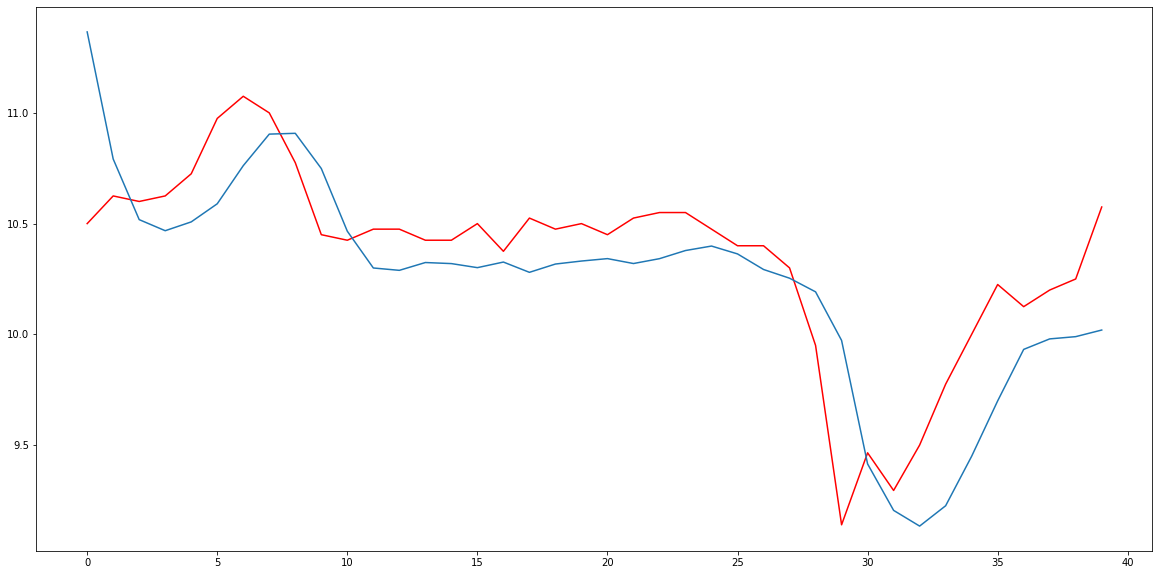

In [185]:
fig, ax = plt.subplots(figsize=[20,10])
ax.plot(real, color='r')
ax.plot(predicted_stock_price)